In [16]:
import csv
import matplotlib.pyplot as plt
from operator import itemgetter, attrgetter
import pandas as pd
import seaborn as sn
import math
import scipy.spatial as spatial
import scipy.stats as stats

In [3]:
#Constants
PENTALY_FOR_NOT_FINISHING = 10 #900s is 15 min computation time
PATH_TO_CSV_FOLDER = '../case-studies/randomModels/2-action-models/' #'../scripts/output/'

## Prepare Data

In [4]:
metaKeys = ["Model", "#States"]

config_keys = [
    "BVI_1",
    "OVI_1_opt",
    #"SVI_1"
]

relevantKeys = metaKeys + config_keys
relevantKeys

['Model', '#States', 'BVI_1', 'OVI_1_opt']

In [5]:
table_times = []
with open(PATH_TO_CSV_FOLDER+'times.csv', newline='\n') as timesFile:
    reader = csv.DictReader(timesFile)
    for row in reader:
        table_times.append({k:row[k] for k in relevantKeys if k in row})
        #table.append(row)

In [6]:
property_meta_keys = ["Model"]

property_keys = [
    "NumStates",
    "NumActions",
    "NumTargets",
    "NumSinks",
    "NumUnknown",
    "NumMaxActions",
    "NumMaxTransitions",
    "SmallestTransProb",
    "NumMECs",
    "BiggestMEC",
    "SmallestMEC",
    "NumSCCs"
]

analysis_keys = property_meta_keys + property_keys

table_properties = []
with open(PATH_TO_CSV_FOLDER+'analysis.csv', newline='\n') as propertiesFile:
        reader = csv.DictReader(propertiesFile)
        for row in reader:
            table_properties.append({k:row[k] for k in analysis_keys if k in row})

In [7]:
#Test Read Filed
for row in table_times:
    #print(row)
    pass

for row in table_properties:
    pass

### Apply Sorting if necessary

In [8]:
table_times = sorted(table_times, key=lambda row: int(row['#States']))
table_properties = sorted(table_properties, key=lambda row: int(row['NumStates']))

## Look at some graph to gain understanding of dataset

In [9]:
x_axis = range(len(table_times)-1)
y_axises = dict()

#Init y_axises
for row in table_times:
    for key in relevantKeys:
        if key == "#States" or key == "Model":
            continue

        if key not in y_axises:
            y_axises[key] = []
        else:
            if (row[key] == ''):
                y_axises[key].append(PENTALY_FOR_NOT_FINISHING)
            else:
                y_axises[key].append(float(row[key]))

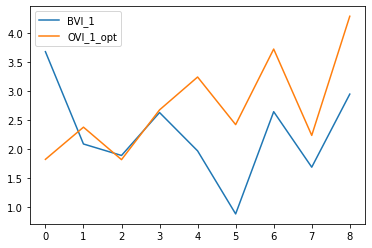

In [10]:
for config in y_axises.keys():
    plt.plot(x_axis, y_axises[config], label=config)
plt.legend()
plt.show()

### Interpret the graph

In [11]:
#Get names of models above certain threshold
threshold = 5

for row in table_times:
    for key in config_keys:
        if row[key] == "":
            print("Model "+row["Model"]+" was not computed by configuration "+key+". Set it's value to "+str(PENTALY_FOR_NOT_FINISHING))
            row[key] = PENTALY_FOR_NOT_FINISHING
        elif row[key] != "" and float(row[key]) > threshold:
            print("For Model "+row["Model"]+" configuration "+key+" requires "+row[key]+"s which is more than "+str(threshold)+"s")
            #row[key] = threshold #Clipping

# Do classic Data Mining stuff

In [12]:
data = dict()
for key in property_keys:
        data[key] = []
for key in config_keys:
        data[key] = []

#Gather the whole data
#Highly inefficient I suppose
for i in range(len(table_times)):
        times_row = table_times[i]
        properties_row_index = -1
        for j in range(len(table_properties)):
                if table_properties[j]["Model"] == times_row["Model"]:
                        properties_row_index = j
                        break
        if (properties_row_index == -1):
                print("ERROR FOR "+times_row["Model"])

        properties_row = table_properties[properties_row_index]

        for key in property_keys:
                if (properties_row[key] == '' or properties_row[key] == ' ' or properties_row[key] == " -"):
                      data[key].append(0)
                else: 
                        data[key].append(float(properties_row[key]))
        for key in config_keys:
                if (times_row[key] == '' or times_row[key] == ' '):
                        data[key].append(PENTALY_FOR_NOT_FINISHING)
                else:
                        data[key].append(float(times_row[key]))

## Heatmaps

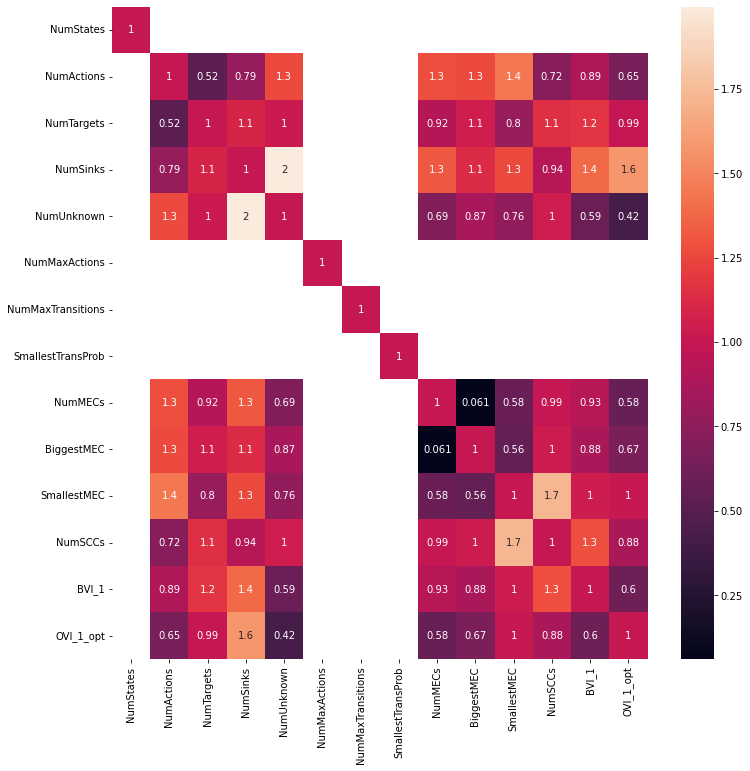

In [19]:
fig = plt.figure(figsize=(12,12))
df = pd.DataFrame(data,columns=property_keys+config_keys)

corrMatrix = df.corr(method=spatial.distance.correlation)
sn.heatmap(corrMatrix, annot=True)
plt.show()


## Scatter Plots

In [26]:
#Scatterplot
def createScatterPlotForOneProperty(property_key):
    entries_per_column = int(math.sqrt(len(config_keys))+1)
    entries_per_row = entries_per_column
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12))
    row = 0
    column = 0
    for key in config_keys:
        if (column == entries_per_column):
            row += 1
            column = 0
        axs[row, column].scatter(data[property_key], data[key])
        axs[row, column].set_xlabel(property_key),
        axs[row, column].set_ylabel(key)
        column+=1

def createScatterPlotForMultipleProperties(property_keys):
    entries_per_column = len(config_keys)
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12))
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            axs[row, column].scatter(data[property_key], data[key])
            axs[row, column].set_xlabel(property_key),
            axs[row, column].set_ylabel(key)
            column+=1

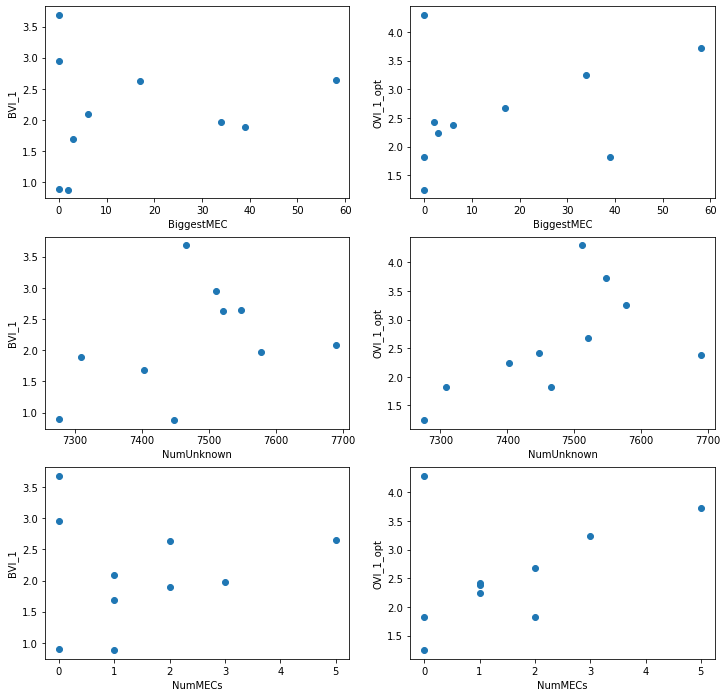

In [27]:
createScatterPlotForMultipleProperties(["BiggestMEC", "NumUnknown", "NumMECs"])